## NCBI Blast an assembly against a nucleotide sequence

This notebook uses output from Megahit or SPAdes assembly and runs Blastn against fasta nucleotide target sequence. It automates the Blast process and then generates a consensus fasta sequence that best matches the query file.

In example below we run on the result of Megahit assemby on SRR11085797 (https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR11085797) 

Our workflow for RaTG13 de-novo anlysis consisted of running this notebook on each of:

- final.contigs.fa MEGAHIT reults using default settings for NCBI accession SRR11085797
- final.contigs.fa MEGAHIT reults using max Kmer of K79 for NCBI accession SRR11085797
- final.contigs.fa MEGAHIT reults using k-step10 and --no-mercy option for NCBI accession SRR11085797
- gene_clusters.fasta CoronaSPAdes results using default settings for NCBI accession SRR11085797
- SRR11806578.fa generated using Biopython from SRR11806578.fastq, sourced from NCBI accession SRR11085797

The consensus fasta files generated from each were then used in the [Fasta_Gap_Comparison.ipynb](files/Fasta_Gap_Comparison.ipynb) notebook to compare overall coverage of the RaTG13 genome

In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio.Blast.Applications import NcbiblastnCommandline 
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import pairwise2  
from Bio.pairwise2 import format_alignment 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
#DATA_PATH='../../RaTG13/Sars_SL3.megahit_asm/'
DATA_PATH='../../RaTG13/Sars_SL3.megahit_asm/intermediate_contigs/'
FASTA_PATH='../../fasta/'

#TARGET_FILE is fasta file that want to match assembly to
TARGET_FILE='MN996532_2_RaTG13_complete_genome.fa'

#ASM_file is assembly output from Megablast/CoronaSPAdes
ASM_FILE='k29.contigs.fa'
METHOD='Megahit default'
COV_NAME='RaTG13'
ASM_CODE='SL3'
UID='mega_defaults_intermediates'

In [3]:
OUT_PATH=DATA_PATH+'blast_analysis/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [4]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
subject_file  = os.path.join(DATA_PATH, ASM_FILE)

In [5]:
assert(os.path.exists(query_file))
assert(os.path.exists(subject_file))

### Blast

Run BLAST and parse the output as XML

Alignment properties: 

'accession', 'hit_def', 'hit_id', 'hsps', 'length', 'title'

hsp properties: 

'align_length', 'bits', 'expect', 'frame', 'gaps', 'identities', 'match', 
        'num_alignments', 'positives', 'query', 'query_end', 'query_start', 'sbjct', 'sbjct_end', 
        'sbjct_start', 'score', 'strand'

In [6]:
def blast_asm(query_file, subject_file, print_summary=False):
    seqs=[]
    lengths=[]
    try:
        output = NcbiblastnCommandline(query=query_file, subject=subject_file, outfmt=5)()[0]
        blast_result_record = NCBIXML.read(StringIO(output))


        for i, alignment in enumerate(blast_result_record.alignments):
            lengths.append(alignment.length)
            for hsp in alignment.hsps:
                seqs.append([hsp.query_start, hsp.query_end, alignment.title, hsp.sbjct])
        if print_summary:
            print(f'{subject_file}, {len(seqs)} Blast hits to {query_file}, lengths: {lengths} ')
    except Exception as e:
        print(e)
    return seqs

In [7]:
seqs=blast_asm(query_file, subject_file, print_summary=True)

../../RaTG13/Sars_SL3.megahit_asm/intermediate_contigs/k29.contigs.fa, 25 Blast hits to ../../fasta/MN996532_2_RaTG13_complete_genome.fa, lengths: [5345, 4591, 3351, 2083, 1753, 1706, 1447, 1168, 989, 936, 780, 645, 575, 537, 499, 425, 425, 334, 277, 228, 198, 170, 112, 112] 


In [8]:
if len(seqs)==0:
    print('No matches found, halting workflow')
    raise ValueError

### Create 2D array of Blast hits

Create a numpy array (faster than pandas dataframe) of size required and fill rows with sequences. We use the '-' character as empty filler.

Later we use this array to build final sequence from assemblies

In [9]:
fasta_target = SeqIO.read(query_file, format="fasta")
fasta_target

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTTCCAGGTAACAAACCAACGAACTCTCGATCTCTTGT...AAA'), id='MN996532.2', name='MN996532.2', description='MN996532.2 Bat coronavirus RaTG13, complete genome', dbxrefs=[])

In [10]:
fasta_seq=str(fasta_target.seq)
fasta_title=fasta_target.description

Add 1 row for target sequence

In [11]:
seq_array=np.tile('-', (len(seqs)+1, len(fasta_seq)))
title_array=np.empty(len(seqs)+1, dtype='str')
seq_array=seq_array.astype('str')

In [12]:
assert seq_array.shape[1]==len(fasta_seq)

In [13]:
seq_array[0]=list(fasta_seq)

In [14]:
title_array[0]=fasta_title
assert seq_array.shape[0]==title_array.shape[0]

In [15]:
seq_array.shape

(26, 29855)

In [16]:
def problem_sequence_gen(start, end, title, subject, target_length):
    ''' 
    Blast on some CoronaSPAdes assemblies generates anomalous outputs
    where hsp.end-hsp.start != len(sequence)
        Either:
        1) start wrong
        2) end wrong
        3) actual sequence not fully used by blast? (where sequence too long)
        
    Here we assume 
        i) if sequence too long, that start and end are correct ie truncate sequence end
        ii) if sequence too short, that start and sequence length are correct
    '''
    #TODO: add option to select to keep full subject sequence
    expected_len=end-(start-1)
    expected_end=start+len(subject)-1
    subject_len_diff=expected_len-len(subject)
    #make independent copy of subject
    subject_mod = ''.join(subject)
    if subject_len_diff>0:
        #expected length longer than actual, ie sequnce too short
        SEQ_LONG=False
        print(f'WARNING sequence too short by {abs(subject_len_diff)} characters, \
        assuming that start and sequence length are correct')
    else:
        SEQ_LONG=True
        print(f'WARNING sequence too long by {abs(subject_len_diff)} characters, \
        truncating sequence end!')
    row=['-'] * (start-1)
    if SEQ_LONG:
        trailer=['-'] * (target_length-end)
        subject_mod=subject_mod[:len(subject_mod) - abs(subject_len_diff)]
    else:
        trailer=['-'] * (target_length-expected_end)
    subject_chars=list(subject_mod)
    row.extend(subject_chars)
    row.extend(trailer)
    if not(len(row)==target_length):
        print(f'built row length: {len(row)}, target length: {target_length}, \
        start: {start}, end: {end}, subject length {len(subject)}, mod subject length: {len(subject_mod)}')
    return row
    

In [17]:
def create_sequence(start, end, title, subject, target_length):
    if not((end-(start-1))==len(subject)):
        return problem_sequence_gen(start, end, title, subject, target_length)
    row=['-'] * (start-1)
    assert end==start+len(subject)-1
    trailer=['-'] * (target_length-end)
    subject_chars=list(subject)
    row.extend(subject_chars)
    row.extend(trailer)
    assert len(row)==target_length
    return row

In [18]:
seq_rows=[]
lengths=[]
for l in seqs:
    #l indexes represent: start, end, title, subject
    row=create_sequence(l[0], l[1], l[2], l[3], len(fasta_seq))
    lengths.append(len(l[3]))
    seq_rows.append(row)

In [19]:
assert len(seq_rows) == len(seqs)

In [20]:
length_sorted=[x for _,x in sorted(zip(lengths,seq_rows), reverse=True)]
titles_sorted=[x for x in length_sorted[2]]

Replace empty values in numpy arry - sorted by length of sequence, row 0 being the target sequence
titles are stored in a separate array

In [21]:
i=0
for l,t in zip(length_sorted,titles_sorted):
    seq_array[i+1]=l
    title_array[i+1]=t
    i+=1

In [22]:
#check or target sequence looks OK
seq_array[0]

array(['A', 'T', 'T', ..., 'A', 'A', 'A'], dtype='<U1')

In [23]:
assert len(seq_array)== len(seqs)+1

### Check against target

The target sequence (here the RaTG13 fasta accession MN996532.2) is in row zero of seq_array as per above. The other rows are each of the Blast hits.


In [24]:
#keep all but target in row 0
nn_only = seq_array[1:]
target=seq_array[0]
equal_checks=np.empty([nn_only.shape[0], nn_only.shape[1]])
for i in range(np.shape(nn_only)[0]):
    #get row
    seq_cmp=nn_only[i]
    equal_check = seq_cmp == target
    equal_check = equal_check.astype(int)
    mask = np.isin(seq_cmp, ['-'])
    #set empty (true) to be 2 temporarily
    equal_check[mask]=2
    equal_checks[i]=equal_check

Swap 2 ('-' ie empty) to be 0 - makes more sense as a zero

In [25]:
equal_checks[equal_checks == 0] = 3
equal_checks[equal_checks == 2] = 0
equal_checks[equal_checks == 3] = 2

assert (np.count_nonzero(equal_checks == 3))==0

In [26]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r'):
    print(f'{METHOD}, {ASM_FILE}, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.savefig(name, dpi=600)
    plt.show()

### Merge into single sequence

Here we create a single consensus fasta file based on a combination of the Blast hits.

Method:

Where only single seuence has coverage - use that

Where 2 or more sequences cover same NN - if NN same, use that, if NN's differ and more of 1 then other use that, if differ and equal number, then use the one that matches the target

In [27]:
def choose_most_freq(frequency, e_idx_val, unique, asm_build):
    '''if not equal fequency then get the most common
    remove empty character (ie e_idx_val) from comparison'''
    temp_freq=frequency.copy().tolist()
    del temp_freq[e_idx_val] 
    temp_freq=temp_freq
    max_freq = np.where(temp_freq == np.amax(temp_freq)) 
    asm_build.append(unique[max_freq][0])  
    return asm_build

In [28]:
nn_only = seq_array[1:]
asm_build=[]
col_idx=0
for column in nn_only.T:
    unique, frequency = np.unique(column,  
                              return_counts = True) 
    if len(unique)==1:
        assert frequency==nn_only.shape[0]
        asm_build.append(unique[0])
    elif len(unique)==2:
        if '-' in unique:
            #highly unlikely this wont be case for this dataset
            not_empty = [x for x in unique if x != '-']
            asm_build.append(not_empty[0])
        else:
            if frequency[0]==frequency[1]:
                #give benefit of doubt
                if unique[0]==seq_array[0][col_idx]:
                    asm_build.append(unique[0])
                else:
                    asm_build.append(unique[1])
            else:
                #if not equal fequency then get the most common
                max_freq = numpy.where(frequency == numpy.amax(frequency)) 
                asm_build.append(unique[max_freq])
    elif len(unique)==3:
        if '-' in unique:
            not_empty = [x for x in unique if x != '-']
            temp_idxs=list(range(3))
            
            empty_idx = np.where(unique == '-')
            e_idx_val=empty_idx[0][0]
            del temp_idxs[e_idx_val] 
            
            if frequency[temp_idxs[0]]==frequency[temp_idxs[1]]:
                #give benefit of doubt
                if unique[temp_idxs[0]]==seq_array[0][col_idx]:
                    asm_build.append(unique[temp_idxs[0]])
                else:
                    asm_build.append(unique[temp_idxs[1]])
            else:
                asm_build=choose_most_freq(frequency, e_idx_val, unique, asm_build)
        else:
            max_freq = numpy.where(frequency == numpy.amax(frequency)) 
            asm_build.append(unique[max_freq])
    elif len(unique)>3:
        if '-' in unique:
            not_empty = [x for x in unique if x != '-']
            temp_idxs=list(range(len(unique)))
            
            empty_idx = np.where(unique == '-')
            e_idx_val=empty_idx[0][0]

            asm_build=choose_most_freq(frequency, e_idx_val, unique, asm_build)
        else:
            max_freq = numpy.where(frequency == numpy.amax(frequency)) 
            asm_build.append(unique[max_freq])
    col_idx+=1

In [29]:
assert len(asm_build)==len(fasta_seq)
assert all(isinstance(x, str) for x in asm_build)

### Plot consensus sequence

In [30]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

Convert to integers to plot

(array([1412.,    0., 8513.,    0.,    0., 5277.,    0., 9081.,    0.,
        5572.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

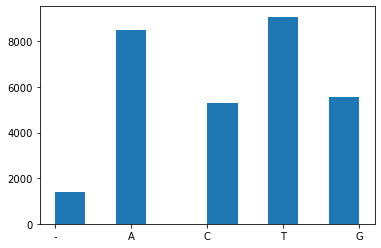

In [31]:
plt.hist(asm_build)

In [32]:
data_ord=ord_v(asm_build)
#replace '-' (empty), with 0 - easier to manage colourmaps
data_ord[data_ord == 45] = 0

In [33]:
#convert to 2D so can plot
stacked=np.stack([data_ord, data_ord], axis=0)

- Dark blue: Continuous coverage by GTCA nucleotides
- Red: Poor coverage, many empty reads
- Yellow: Very poor coverage
- White: No reads

Megahit default, k29.contigs.fa, stack_arr: (1000, 29855)


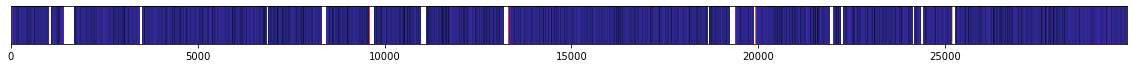

In [34]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
plot_blocked_seq(stacked_repeated, name=OUT_PATH+f'asm_stitched_{UID}.png')

In [35]:
target=seq_array[0]

asm_check = asm_build == target
asm_check = asm_check.astype(int)
mask = np.isin(asm_build, ['-'])
#set empty (true) to be 2 temporarily
asm_check[mask]=2
asm_check[asm_check == 0] = 3
asm_check[asm_check == 2] = 0
asm_check[asm_check == 3] = 2
#0: empty; 1: NN match, 2: NN incorrect (based on consensus id more than 1)

In [36]:
unique, frequency = np.unique(asm_check,  
                              return_counts = True) 
print(f'unique: {unique}, frequency: {frequency}')

unique: [0 1 2], frequency: [ 1412 28431    12]


In [37]:
def export_fasta(out_file_path, sequence, id_text, description):
    if isinstance(sequence, list):
        sequence = ''.join(sequence)
    seq=Seq(sequence)
    record=SeqRecord(seq, id=id_text, description=description)
    with open(out_file_path, "w") as output_handle:
        SeqIO.write(record, output_handle, "fasta")

In [38]:
export_fasta(OUT_PATH+f'{COV_NAME}_{ASM_CODE}_{UID}.fa', asm_build, f'{COV_NAME}_{ASM_CODE}_{UID}', METHOD)

### Stats

In [39]:
correct_seq=f'Percentage of full sequence with correct sequence coverage: {(frequency[1]/len(fasta_seq))*100}%'

greater than 1 where segments overlp

In [40]:
correct_overlap=f'Percentage of full sequence with correct overlapping sequences: {(frequency[2]/len(fasta_seq))*100}%'

In [41]:
missing=f'Percentage missing: {(frequency[0]/len(fasta_seq))*100}%'

In [42]:
print(correct_seq)
print(correct_overlap)
print(missing)

Percentage of full sequence with correct sequence coverage: 95.23027968514486%
Percentage of full sequence with correct overlapping sequences: 0.04019427231619494%
Percentage missing: 4.7295260425389385%


In [43]:
with open(OUT_PATH+f"{COV_NAME}_{ASM_CODE}_{UID}_stats.txt", "w") as text_file:
    text_file.write(correct_seq +'\n')
    text_file.write(correct_overlap +'\n')
    text_file.write(missing +'\n')

### Plot Blast Hits

Top row: consensus sequence, white- no coverage

Second row: spacer

Each row below show each contig from Blast

In [44]:
equal_checks.shape

(25, 29855)

In [45]:
bin_stacked_repeated = np.repeat(stacked, repeats=250, axis=0)
bin_stacked_repeated[bin_stacked_repeated > 0] = 1

#add a gap
bin_zero_repeated = np.repeat(stacked, repeats=250, axis=0)
bin_zero_repeated[bin_stacked_repeated > 0] = 0
stacked_header=np.stack([bin_stacked_repeated, bin_zero_repeated], axis=0)

In [46]:
stacked_header=stacked_header.reshape((bin_stacked_repeated.shape[0]+bin_zero_repeated.shape[0], bin_zero_repeated.shape[1]))

In [47]:
equal_repeated = np.repeat(equal_checks, repeats=500, axis=0)
stack_arr=np.concatenate((stacked_header,equal_repeated), axis=0)

Megahit default, k29.contigs.fa, stack_arr: (13500, 29855)


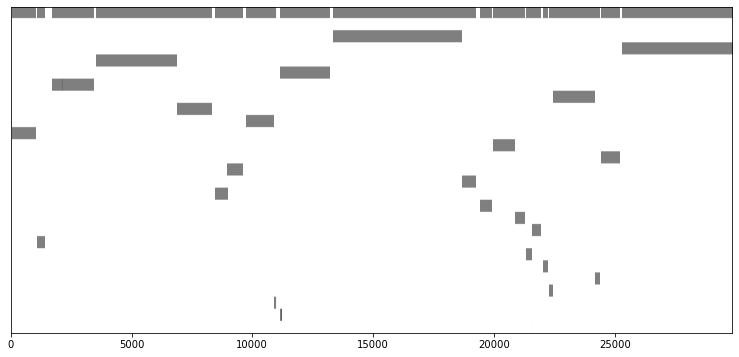

In [48]:
plot_blocked_seq(stack_arr, name=OUT_PATH+f'equal_repeated_{UID}.png', cmap='gray_r')

### Misc Plotting

The plot blow is experimental and was not used for any analysis. 

Note, different to plots above, the first row in plot here shows the target sequence not consensus sequence. 

In [49]:
nn_unique=np.unique(seq_array)
ord_unique=np.unique(ord_v(seq_array))
unique_codes = dict(zip(list(range(len(ord_unique))), ord_unique))

In [50]:
def replce_npy(a, val_list, replace_with):
    for v,r in zip(val_list, replace_with):
        [[_el if _el == v else r for _el in _ar] for _ar in a]

In [51]:
def get_plot_data(seq_array, unique_codes, labels):
    data_ord=ord_v(seq_array)
    unique, frequency = np.unique(seq_array,  
                              return_counts = True) 
    print(f'Unique Nucleotides: {unique}, frequency: {frequency}')
    for n,o in zip(nn_unique, ord_unique):
        #use the unique NN code (order unknown) as loopup in the colourbar list
        idx=np.where(labels == n.upper())
        #key = next(key for key, value in dd.items() if value == v)
        data_ord=np.where(data_ord==o, idx, data_ord)
    #repeat to expand y axis 
    data_repeated = np.repeat(data_ord, repeats=500, axis=0)
    return data_repeated

In [52]:
def plot_nn_colourbars():
    #after https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar

    col_dict={0:"white",
              1:"blue",
              2:"yellow",
              3:"red",
              4:"green",
              5:"magenta",
              6:"black",
              7:"tan",
              8:"darkgreen",
              9:"lavender",
              10:"lightcoral",
              11:"aquamarine",
              12:"lightcyan",
              13:"orchid",
              14:"coral",
              15:"olive",
              16:"lightblue"
             }

    # create a colormap from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    #in order of here: https://www.genome.jp/kegg/catalog/codes1.html
    labels = np.array(["-","A","G","C","T","U","R","Y","N","W", "S","M","K","B","H","D","V"])
    len_lab = len(labels)

    # prepare normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

    norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    data_repeated=get_plot_data(seq_array, unique_codes, labels)

    #plt.matshow(data_repeated, cmap=cm, norm=norm)

    fig,ax = plt.subplots(figsize=(20, 10))
    
    im = ax.imshow(data_repeated, cmap=cm, norm=norm)

    ax.axes.yaxis.set_visible(False)
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    ax.axes.yaxis.set_visible(False)
    plt.title(f'Target: {TARGET_FILE} (top row) vs contigs using {METHOD}', fontsize=12)
    fig.savefig(OUT_PATH+f"colour_sequence_map_{UID}.png")
    plt.show()

Unique Nucleotides: ['-' 'A' 'C' 'G' 'T'], frequency: [717727  17486  10818  11456  18743]


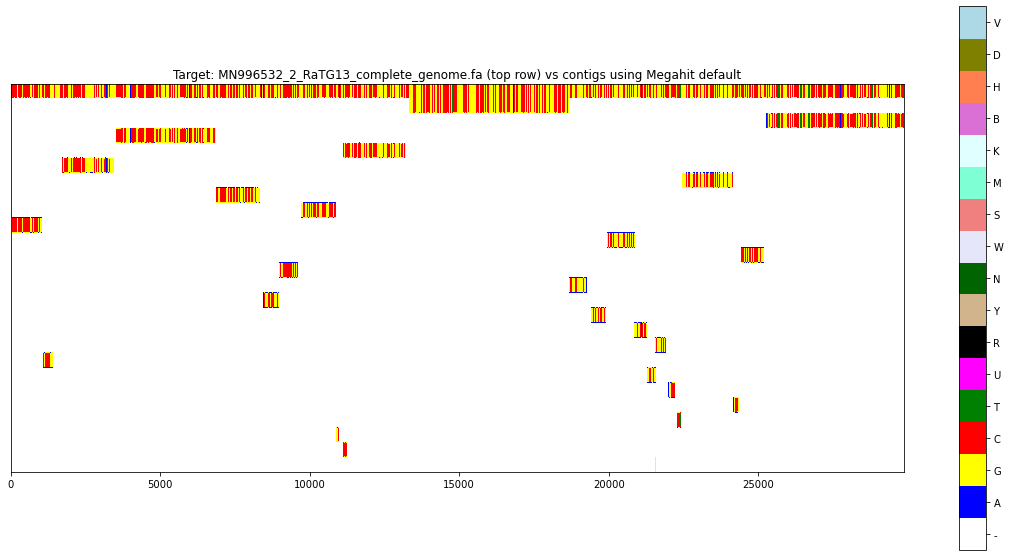

In [53]:
#TODO, use bokeh for revised version so can zoom and explore
plot_nn_colourbars()

(array([8922.,    0.,    0., 9579.,    0.,    0., 5847.,    0.,    0.,
        5507.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

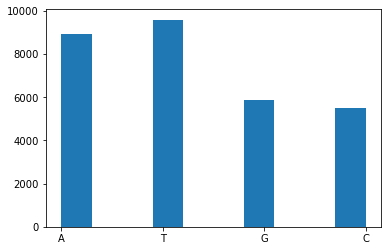

In [54]:
#odd that plot above looks like mostly G & C - needs testing
plt.hist(seq_array[0])

### References

Zhou, P., Yang, XL., Wang, XG. et al., 2020a. A pneumonia outbreak associated with a new coronavirus of probable bat origin. Nature 579, 270–273 (2020). https://doi.org/10.1038/s41586-020-2012-7
